# Decision Trees using Scikit-Learn

**AUTHOR**: Alma Qasreena

This Jupyter Notebook provide the example of simple Machine Learning classification using Scikit-Learn

We will be using the following modelling techniques:

-Deep Neural Network (DNN)

-Decision Tree

-AdaBoost

-Gradient Boosting

AdaBoost and Gradient Boosting is one of the most popular boosting algorithm method for Decision Tree that is shown in this notebook

We begin by importing a few essential libraries and then load the data sets that will be use

In [65]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
# Use flag to make it easier to compare the line produced by DNN, Decision Tree, AdaBoost, Gradient Boosting
PLOT    = True
DO_DNN  = True
DO_DT   = True
DO_AB   = True
DO_GB   = True
VERBOSE = False

In [67]:
# load the ROOT files

filePath   =  '../files/JetNtuple_RunIISummer16_13TeV_MC_1_skimmed.root'
tree       =   uproot.open(filePath)['jetTree']

In [68]:
# Create and fill a dataframe
df             = pd.DataFrame()
remaining_vars = []

In [69]:
for key in tree.keys():

    if str(type(tree[key].array()[0])) != "<class 'awkward.highlevel.Array'>":
        df[key] = np.array(tree[key].array())
    else:
        remaining_vars.append(key)
    pass


In [70]:
if VERBOSE:      
    print("Remaining variables not accounted for:")
    print(remaining_vars)


In [71]:
# First remove all the other types of jets from the data except the gluon and the light quark (UDS) jets
df = df[(df.isPhysG==1) | (df.isPhysUDS==1)].reset_index()

In [72]:
if VERBOSE: print(df)

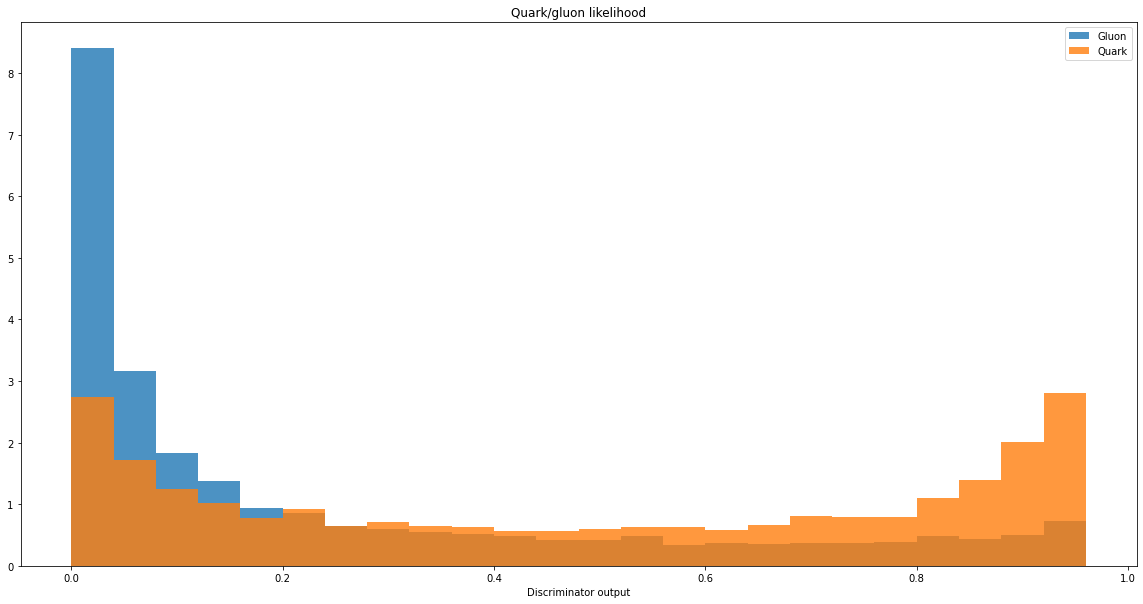

In [73]:
if PLOT:
    #
    #Plotting Variables
    #

    hist_columns = ['QG_mult','QG_ptD','QG_axis2']
    binnings = [np.arange(0,70,2), np.arange(0.0,1.0,0.04), np.arange(0.0,0.2,0.01)]
    ind = 0
    fig, axes = plt.subplots(1, 3, figsize=(20,10))

    for column in hist_columns:
        axes[ind].hist( df[df.isPhysG==1][column], bins=binnings[ind], alpha=0.8, label='Gluon', density=1 )
        axes[ind].hist( df[df.isPhysUDS==1][column], bins=binnings[ind], alpha=0.8, label='Quark', density=1 )
        axes[ind].set_xlabel(column)
        axes[ind].legend()
        ind = ind+1

    plt.savefig("./ML_vars.png")
    plt.clf()

    binning = np.arange(0.0, 1.0, 0.04)
    plt.hist( df[df.isPhysG==1]['jetQGl'], bins=binning, alpha=0.8, label='Gluon', density=1 )
    plt.hist( df[df.isPhysUDS==1]['jetQGl'], bins=binning, alpha=0.8, label='Quark', density=1 )
    plt.legend()
    plt.xlabel('Discriminator output')
    plt.title('Quark/gluon likelihood');



In [74]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

test_y = test.isPhysUDS

input_features = ['jetPt', 'jetEta', 'QG_mult', 'QG_ptD', 'QG_axis2']

if DO_DNN:

    train_y_dnn = train.isPhysUDS
    test_y_dnn = test.isPhysUDS

    train_x_dnn = train[input_features]
    test_x_dnn = test[input_features]

    train_x_dnn_mean = train_x_dnn.mean()
    train_x_dnn_std = train_x_dnn.std()

    train_x_dnn = (train_x_dnn - train_x_dnn_mean) / train_x_dnn_std
    test_x_dnn = (test_x_dnn - train_x_dnn_mean) / train_x_dnn_std

if DO_DT:

    train_y_dt = train.isPhysUDS
    test_y_dt = test.isPhysUDS

    train_x_dt = train[input_features]
    test_x_dt = test[input_features]

    train_x_dt_mean = train_x_dt.mean()
    train_x_dt_std = train_x_dt.std()

    train_x_dt = (train_x_dt - train_x_dt_mean) / train_x_dt_std
    test_x_dt = (test_x_dt - train_x_dt_mean) / train_x_dt_std

if DO_AB:

    train_y_ab = train.isPhysUDS
    test_y_ab = test.isPhysUDS

    train_x_ab = train[input_features]
    test_x_ab = test[input_features]

    train_x_ab_mean = train_x_ab.mean()
    train_x_ab_std = train_x_ab.std()

    train_x_ab = (train_x_ab - train_x_ab_mean) / train_x_ab_std
    test_x_ab = (test_x_ab - train_x_ab_mean) / train_x_ab_std


if DO_GB:

    train_y_gb = train.isPhysUDS
    test_y_gb = test.isPhysUDS

    train_x_gb = train[input_features]
    test_x_gb = test[input_features]

    train_x_gb_mean = train_x_gb.mean()
    train_x_gb_std = train_x_gb.std()

    train_x_gb = (train_x_gb - train_x_gb_mean) / train_x_gb_std
    test_x_gb = (test_x_gb - train_x_gb_mean) / train_x_gb_std


In [75]:
if DO_DNN:

    #
    # Deep Neural Network (DNN)
    #
    import tensorflow as tf
    import keras.backend as K

    sess = tf.compat.v1.Session()
    tf.compat.v1.keras.backend.set_session(sess)

    from keras.models import Model, Sequential
    from keras.layers import Input, Dense, Dropout
    from sklearn.utils import class_weight

    # Define the DNN architecture
    model = Sequential()
    model.add(Dense(100, kernel_initializer='normal', activation='relu', input_dim=train_x_dnn.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])

    # Weight the training samples so that there is equal weight on gluon and quark jets
    # even if there are different amount of them in the training set
    class_weights = class_weight.compute_class_weight(
                                                        class_weight  = 'balanced',
                                                        classes  = np.unique(train_y_dnn),
                                                        y =   train_y_dnn
                                                    )

    class_weights = dict(zip(np.unique(train_y_dnn), class_weights))

    # Train the model
    model.fit(train_x_dnn,
              train_y_dnn,
              epochs=20,
              batch_size=128,
              class_weight=class_weights,
              validation_split=0.2,
              shuffle=True,
              verbose=1);

    pred_y_dnn = model.predict(test_x_dnn)

2021-12-29 16:32:43.410762: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-29 16:32:43.945100: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-29 16:32:43.961307: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1497600000 Hz


Epoch 1/20
70/70 [==============================] - 3s 19ms/step - loss: 0.6404 - accuracy: 0.7139 - val_loss: 0.5107 - val_accuracy: 0.7448
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 0.5276 - accuracy: 0.7431 - val_loss: 0.5130 - val_accuracy: 0.7493
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 0.5268 - accuracy: 0.7506 - val_loss: 0.5026 - val_accuracy: 0.7538
Epoch 4/20
70/70 [==============================] - 1s 7ms/step - loss: 0.5225 - accuracy: 0.7472 - val_loss: 0.5020 - val_accuracy: 0.7547
Epoch 5/20
70/70 [==============================] - 1s 8ms/step - loss: 0.5196 - accuracy: 0.7522 - val_loss: 0.5085 - val_accuracy: 0.7489
Epoch 6/20
70/70 [==============================] - 1s 8ms/step - loss: 0.5211 - accuracy: 0.7480 - val_loss: 0.5103 - val_accuracy: 0.7547
Epoch 7/20
70/70 [==============================] - 1s 9ms/step - loss: 0.5243 - accuracy: 0.7468 - val_loss: 0.5147 - val_accuracy: 0.7529
Epoch 8/20
70/70 [=

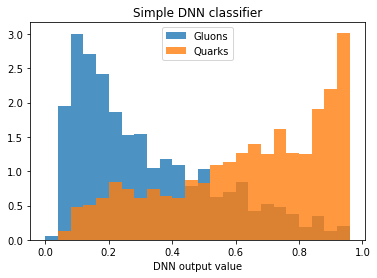

In [76]:
if PLOT and DO_DNN:

    plt.clf()
    binning = np.arange(0.0, 1.0, 0.04)
    plt.hist( pred_y_dnn[test_y_dnn==0], bins=binning, alpha=0.8, label="Gluons", density=1 )
    plt.hist( pred_y_dnn[test_y_dnn==1], bins=binning, alpha=0.8, label="Quarks", density=1 )
    plt.legend()
    plt.xlabel('DNN output value')
    plt.title('Simple DNN classifier');
    

In [77]:
if DO_DT:

    from sklearn.tree import DecisionTreeClassifier

    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(train_x_dt, train_y_dt)

    pred_y_dt = clf.apply(test_x_dt)

if DO_AB:

    from sklearn.ensemble import AdaBoostClassifier 

    clf = AdaBoostClassifier(n_estimators=100, random_state=0)
    clf.fit(train_x_ab, train_y_ab)

    pred_y_ab = clf.decision_function(test_x_ab)


if DO_GB:

    from sklearn.ensemble import GradientBoostingClassifier

    clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
    clf.fit(train_x_gb, train_y_gb)

    pred_y_gb = clf.decision_function(test_x_gb)

In [78]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

if DO_DNN:
    fpr_dnn, tpr_dnn, thresholds_dnn  = roc_curve(test_y_dnn, pred_y_dnn)
    roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

if DO_DT:
    fpr_dt, tpr_dt, thresholds_dt  = roc_curve(test_y_dt, pred_y_dt)
    roc_auc_dt = auc(fpr_dt, tpr_dt)

if DO_AB:
    fpr_ab, tpr_ab, thresholds_ab  = roc_curve(test_y_ab, pred_y_ab)
    roc_auc_ab = auc(fpr_ab, tpr_ab)

if DO_GB:
    fpr_gb, tpr_gb, thresholds_gb  = roc_curve(test_y_gb, pred_y_gb)
    roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_qgl, tpr_qgl, thresholds_qgl = roc_curve(test_y, test.jetQGl)
roc_auc_qgl = auc(fpr_qgl, tpr_qgl)


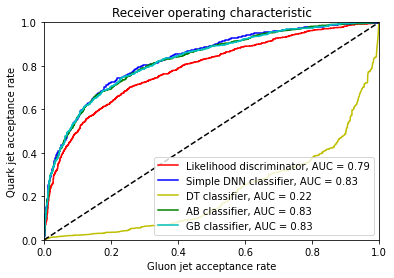

In [79]:
if PLOT:

    plt.clf()
    plt.plot(fpr_qgl, tpr_qgl, 'r', label='Likelihood discriminator, AUC = %0.2f'% roc_auc_qgl)

    if DO_DNN: plt.plot(fpr_dnn, tpr_dnn, 'b', label='Simple DNN classifier, AUC = %0.2f'% roc_auc_dnn)
    if DO_DT : plt.plot(fpr_dt , tpr_dt , 'y', label='DT classifier, AUC = %0.2f'% roc_auc_dt)
    if DO_AB : plt.plot(fpr_ab , tpr_ab , 'g', label='AB classifier, AUC = %0.2f'% roc_auc_ab)
    if DO_GB : plt.plot(fpr_gb , tpr_gb , 'c', label='GB classifier, AUC = %0.2f'% roc_auc_gb)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc = 'lower right')
    plt.title("Receiver operating characteristic")
    plt.ylabel('Quark jet acceptance rate')
    plt.xlabel('Gluon jet acceptance rate');
